# Defining the Fully Convolutional Neural Network

In [29]:
import os
import cv2
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pickle

from PIL import Image
from matplotlib import cm
import matplotlib.pyplot as plt
from torchsummary import summary

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [54]:
class FCNN(nn.Module):
    """
    This is a class for fully convolutional neural networks.
    
    It is a subclass of the Module class from torch.nn.
    See the torch.nn documentation for more information.
    """
    
    def __init__(self):
        """
        The constructor for FCNN class. The internal states of the network are initialized. 
        """
        
        super(FCNN, self).__init__()
        self.conv0 = nn.Conv2d(in_channels=1, out_channels=30, kernel_size=2, stride=2)
        
        self.conv1 = nn.Conv2d(in_channels=30, out_channels=30, kernel_size=5, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=30, out_channels=60, kernel_size=3, stride=1)
        self.conv2_drop = nn.Dropout2d()
        
        self.conv3 = nn.Conv2d(in_channels=60, out_channels=60, kernel_size=3, stride=2)
        self.conv3_drop = nn.Dropout2d()
        
        self.conv4 = nn.Conv2d(in_channels=60, out_channels=120, kernel_size=3, stride=1)
        
        self.conv5 = nn.Conv2d(in_channels=120, out_channels=120, kernel_size=3, stride=1)
        
        self.conv6 = nn.Conv2d(in_channels=120, out_channels=1, kernel_size=1, stride=1)
        
        
    def forward(self, data):
        """
        Defines the computation performed at every call.
        
        Parameters:
            data (4D-tensor): The input that is evaluated by the network.
            
        Returns:
            x (tensor): The output of the network after evaluating it on the given input.
        """
        
        x = F.relu(self.conv0(data))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2_drop(self.conv2(x)))
        x = F.relu(self.conv3_drop(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = torch.sigmoid(self.conv6(x))
        return x
    

# Create a new instance of the FCNN class. This will be our network.      
network = FCNN().to(device)

In [4]:
summary(network, (1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 30, 32, 32]             150
            Conv2d-2           [-1, 30, 14, 14]          22,530
            Conv2d-3           [-1, 60, 12, 12]          16,260
         Dropout2d-4           [-1, 60, 12, 12]               0
            Conv2d-5             [-1, 60, 5, 5]          32,460
         Dropout2d-6             [-1, 60, 5, 5]               0
            Conv2d-7            [-1, 120, 3, 3]          64,920
            Conv2d-8            [-1, 120, 1, 1]         129,720
            Conv2d-9              [-1, 1, 1, 1]             121
Total params: 266,161
Trainable params: 266,161
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.44
Params size (MB): 1.02
Estimated Total Size (MB): 1.47
-------------------------------------------

# Loading the samples

In [5]:
POLLEN_DATA_CREATED = False
cur_dir = os.getcwd()
pollen_files = cur_dir + '/Datasets/PollenData64new/'
np_pollen_data = []     # single date will be [img,label]


if not POLLEN_DATA_CREATED:
    for folder in next(os.walk(pollen_files))[1]:
        if folder == 'p':
            label = 1
        else:
            label = 0
        parent_path = os.path.join(pollen_files, folder)
        for file in os.listdir(parent_path):
            if '.png' in file:
                try:
                    path = os.path.join(parent_path, file)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    np_pollen_data.append([np.array(img), label])
                except Exception as e:
                    print(folder, file, str(e))

    np.random.shuffle(np_pollen_data)
    print("Data created.")


Data created.


In [6]:
# seperate the images and the corresponding labels into two lists:

images = []
labels = []

for i in range(len(np_pollen_data)):
    images.append(np_pollen_data[i][0])
    labels.append(np_pollen_data[i][1])

print(len(images))

1907100


In [7]:
# Split the data into train and validation set;
# we do not want to test the network on the data we already used for the training.

train_x = images[:int(len(images)*0.4)]
train_y = labels[:int(len(images)*0.4)]
valid_x = images[int(len(images)*0.4):int(len(images)*0.5)]
valid_y = labels[int(len(images)*0.4):int(len(images)*0.5)]

In [8]:
print(images[1].shape)

(64, 64)


In [9]:
# Our neural network expects a dataloader. Thus, we 

trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.Tensor(train_x),torch.Tensor(train_y)),batch_size=32)
validloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.Tensor(valid_x),torch.Tensor(valid_y)),batch_size=100)

# Train the Network

First we have a look at the performance of the untrained model on our validation set. 

In [10]:
ep = 10
threshold = 0.8

#Which optimizer and criterion should we choose? Perform best?
criterion = nn.MSELoss()
optimizer = optim.SGD(network.parameters(), lr=0.001, momentum=0.9)


### Validation

In [11]:
def validate(network, testloader):
    """
    Calculates the mean validation loss, the F1-Score and the accuracy of the given network on the testloader data.
    
    Parameters:
        network (): The network to validate. 
        testloader (torch.utils.data.DataLoader): Contains the data which is used to validate the network. 
        
    Returns:
        validation_loss (): The mean loss per image with regards to a fixed criterion.
        F1_Score (): The harmonic mean of the precision and the recall of the given network
            on the given validation data.
        correct / total (): The percentage of correctly classified samples of the total number of validation samples.
        
    """
    
    total = 0
    correct = 0
    true_positive = 0
    false_negative = 0
    false_positive = 0
    true_negative = 0

    # We do not need any gradiants here, since we do not train the network.
    # We are only interested in the predictions of the network on the testdata. 
    with torch.no_grad():
        validation_loss = 0
        for i, (inputs, labels) in enumerate(testloader):
            
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = network(torch.transpose(inputs[...,None],1,3)).view(-1)
            #print(labels.size(0))
            loss = criterion(outputs,labels)
            validation_loss += loss.item()
            predicted = (outputs >= threshold) # Predicted is a tensor of booleans 
            total += labels.size(0)
            predicted = predicted.view(predicted.size(0)) 
            #print(labels.size())
            #print((predicted == labels).sum().item())
            labels = labels == 1
            correct += (predicted == labels).sum().item()
            true_positive += (predicted & labels).sum().item()
            false_negative += (torch.logical_not(predicted) & labels).sum().item()
            false_positive += (predicted & torch.logical_not(labels)).sum().item()
            true_negative += (torch.logical_not(predicted) & torch.logical_not(labels)).sum().item()
            
        validation_loss = validation_loss / total 
        
        try: 
            recall = true_positive / (true_positive + false_negative)
        except ZeroDivisionError:
            recall = 0
        try:
            precision = true_positive / (true_positive + false_positive)
        except ZeroDivisionError:
            precision = 0
        try:
            F1_score = 2 * (precision * recall) / (precision + recall)
        except ZeroDivisionError:
            F1_score = 0
            
    
    print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
    print('F1 Score of the network on the test images: %f' % F1_score)
    return validation_loss, F1_score, (correct / total)
    
validate(network, validloader)

Accuracy of the network on the test images: 89 %
F1 Score of the network on the test images: 0.000000


(0.0022523879512631145, 0, 0.8977819726285984)

### Training

In [12]:
# from pytorch blitz tutorial

def train(network, trainloader, ep, criterion, optimizer, print_interval):
    """
    Train a neural network.
    
    
    Parameters:
        network ():
        trainloader ():
        ep (int): The number of epochs the network will be trained for.
        criterion ():
        optimizer ():
        print_interval (int): The number of batches after which the function prints the loss for one batch.
    
    Returns:
        train_losses ([float]): The mean of the loss for one train sample after every epoch. 
        validation_losses ([float]): The mean of the loss for one validation sample after every epoch.
        F1 ([float]): The F1-Score of the validation data after every epoch.
        accuracy ([float]): The accuracy of the network on the validation data after every epoch.
    """
    
    losses = [] # Mean of loss/image in every epoch of training 
    validation_losses = []
    F1 = []
    accuracy = []
    validate(network, validloader)
    
    for epoch in range(ep):

        loss_stats = 0.0
        total = 0
        
        running_loss = 0.0
    
        for i, (inputs, lables) in enumerate(trainloader):
            
            inputs, lables = inputs.to(device), lables.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            #print(lables.shape)
            
            outputs = network(torch.transpose(inputs[...,None],1,3)).view(-1)
            #print(outputs.shape)
            loss = criterion(outputs, lables)
            loss.backward() #propagate the error back through the network
            optimizer.step() #adjust the weights of the network depending on the propagated error
    
            #that's it.
            total += lables.shape[0]
            
            #Some statistics:
            running_loss += loss.item()
            
            loss_stats += loss.item()
            
            if i % print_interval == print_interval - 1:    # print every x mini-batches (loss for one batch)
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / print_interval))
                running_loss = 0.0
        
        losses.append(loss_stats / total)
        #Test the network using the validation set after every epoch of training.
        val_loss_curr, F1_curr, accuracy_curr = validate(network, validloader)
        validation_losses.append(val_loss_curr)
        F1.append(F1_curr)
        accuracy.append(accuracy_curr)
        
    print('Finished Training')
    return losses, validation_losses, F1, accuracy

train_losses, val_losses, F1_scores, accuracies = train(network, trainloader, ep, criterion, optimizer, 32)

Accuracy of the network on the test images: 89 %
F1 Score of the network on the test images: 0.000000
[1,    32] loss: 0.112
[1,    64] loss: 0.110
[1,    96] loss: 0.108
[1,   128] loss: 0.103
[1,   160] loss: 0.116
[1,   192] loss: 0.104
[1,   224] loss: 0.111
[1,   256] loss: 0.107
[1,   288] loss: 0.101
[1,   320] loss: 0.086
[1,   352] loss: 0.083
[1,   384] loss: 0.101
[1,   416] loss: 0.113
[1,   448] loss: 0.088
[1,   480] loss: 0.080
[1,   512] loss: 0.070
[1,   544] loss: 0.064
[1,   576] loss: 0.053
[1,   608] loss: 0.051
[1,   640] loss: 0.043
[1,   672] loss: 0.039
[1,   704] loss: 0.047
[1,   736] loss: 0.046
[1,   768] loss: 0.043
[1,   800] loss: 0.032
[1,   832] loss: 0.036
[1,   864] loss: 0.040
[1,   896] loss: 0.047
[1,   928] loss: 0.035
[1,   960] loss: 0.047
[1,   992] loss: 0.038
[1,  1024] loss: 0.039
[1,  1056] loss: 0.043
[1,  1088] loss: 0.041
[1,  1120] loss: 0.041
[1,  1152] loss: 0.019
[1,  1184] loss: 0.037
[1,  1216] loss: 0.035
[1,  1248] loss: 0.044
[

[1, 11296] loss: 0.032
[1, 11328] loss: 0.018
[1, 11360] loss: 0.025
[1, 11392] loss: 0.018
[1, 11424] loss: 0.022
[1, 11456] loss: 0.024
[1, 11488] loss: 0.025
[1, 11520] loss: 0.030
[1, 11552] loss: 0.025
[1, 11584] loss: 0.021
[1, 11616] loss: 0.018
[1, 11648] loss: 0.024
[1, 11680] loss: 0.022
[1, 11712] loss: 0.028
[1, 11744] loss: 0.025
[1, 11776] loss: 0.016
[1, 11808] loss: 0.021
[1, 11840] loss: 0.025
[1, 11872] loss: 0.020
[1, 11904] loss: 0.021
[1, 11936] loss: 0.025
[1, 11968] loss: 0.021
[1, 12000] loss: 0.026
[1, 12032] loss: 0.018
[1, 12064] loss: 0.019
[1, 12096] loss: 0.018
[1, 12128] loss: 0.019
[1, 12160] loss: 0.026
[1, 12192] loss: 0.025
[1, 12224] loss: 0.023
[1, 12256] loss: 0.023
[1, 12288] loss: 0.022
[1, 12320] loss: 0.020
[1, 12352] loss: 0.018
[1, 12384] loss: 0.025
[1, 12416] loss: 0.030
[1, 12448] loss: 0.025
[1, 12480] loss: 0.016
[1, 12512] loss: 0.020
[1, 12544] loss: 0.015
[1, 12576] loss: 0.022
[1, 12608] loss: 0.025
[1, 12640] loss: 0.018
[1, 12672] 

[1, 22720] loss: 0.024
[1, 22752] loss: 0.021
[1, 22784] loss: 0.016
[1, 22816] loss: 0.026
[1, 22848] loss: 0.023
[1, 22880] loss: 0.019
[1, 22912] loss: 0.022
[1, 22944] loss: 0.024
[1, 22976] loss: 0.025
[1, 23008] loss: 0.024
[1, 23040] loss: 0.021
[1, 23072] loss: 0.019
[1, 23104] loss: 0.020
[1, 23136] loss: 0.026
[1, 23168] loss: 0.020
[1, 23200] loss: 0.013
[1, 23232] loss: 0.017
[1, 23264] loss: 0.020
[1, 23296] loss: 0.017
[1, 23328] loss: 0.019
[1, 23360] loss: 0.020
[1, 23392] loss: 0.025
[1, 23424] loss: 0.016
[1, 23456] loss: 0.021
[1, 23488] loss: 0.019
[1, 23520] loss: 0.021
[1, 23552] loss: 0.022
[1, 23584] loss: 0.023
[1, 23616] loss: 0.024
[1, 23648] loss: 0.026
[1, 23680] loss: 0.020
[1, 23712] loss: 0.018
[1, 23744] loss: 0.015
[1, 23776] loss: 0.020
[1, 23808] loss: 0.026
Accuracy of the network on the test images: 97 %
F1 Score of the network on the test images: 0.832274
[2,    32] loss: 0.021
[2,    64] loss: 0.020
[2,    96] loss: 0.017
[2,   128] loss: 0.020
[

[2, 10176] loss: 0.019
[2, 10208] loss: 0.023
[2, 10240] loss: 0.023
[2, 10272] loss: 0.024
[2, 10304] loss: 0.016
[2, 10336] loss: 0.019
[2, 10368] loss: 0.020
[2, 10400] loss: 0.014
[2, 10432] loss: 0.014
[2, 10464] loss: 0.015
[2, 10496] loss: 0.020
[2, 10528] loss: 0.020
[2, 10560] loss: 0.022
[2, 10592] loss: 0.019
[2, 10624] loss: 0.017
[2, 10656] loss: 0.021
[2, 10688] loss: 0.019
[2, 10720] loss: 0.016
[2, 10752] loss: 0.016
[2, 10784] loss: 0.021
[2, 10816] loss: 0.016
[2, 10848] loss: 0.022
[2, 10880] loss: 0.017
[2, 10912] loss: 0.020
[2, 10944] loss: 0.013
[2, 10976] loss: 0.016
[2, 11008] loss: 0.015
[2, 11040] loss: 0.023
[2, 11072] loss: 0.016
[2, 11104] loss: 0.015
[2, 11136] loss: 0.016
[2, 11168] loss: 0.030
[2, 11200] loss: 0.020
[2, 11232] loss: 0.023
[2, 11264] loss: 0.019
[2, 11296] loss: 0.027
[2, 11328] loss: 0.014
[2, 11360] loss: 0.022
[2, 11392] loss: 0.017
[2, 11424] loss: 0.015
[2, 11456] loss: 0.020
[2, 11488] loss: 0.021
[2, 11520] loss: 0.023
[2, 11552] 

[2, 21600] loss: 0.015
[2, 21632] loss: 0.017
[2, 21664] loss: 0.019
[2, 21696] loss: 0.026
[2, 21728] loss: 0.020
[2, 21760] loss: 0.018
[2, 21792] loss: 0.022
[2, 21824] loss: 0.019
[2, 21856] loss: 0.024
[2, 21888] loss: 0.020
[2, 21920] loss: 0.016
[2, 21952] loss: 0.017
[2, 21984] loss: 0.018
[2, 22016] loss: 0.012
[2, 22048] loss: 0.022
[2, 22080] loss: 0.018
[2, 22112] loss: 0.015
[2, 22144] loss: 0.018
[2, 22176] loss: 0.013
[2, 22208] loss: 0.019
[2, 22240] loss: 0.014
[2, 22272] loss: 0.022
[2, 22304] loss: 0.019
[2, 22336] loss: 0.015
[2, 22368] loss: 0.014
[2, 22400] loss: 0.021
[2, 22432] loss: 0.017
[2, 22464] loss: 0.022
[2, 22496] loss: 0.015
[2, 22528] loss: 0.015
[2, 22560] loss: 0.027
[2, 22592] loss: 0.019
[2, 22624] loss: 0.021
[2, 22656] loss: 0.016
[2, 22688] loss: 0.019
[2, 22720] loss: 0.022
[2, 22752] loss: 0.016
[2, 22784] loss: 0.015
[2, 22816] loss: 0.019
[2, 22848] loss: 0.024
[2, 22880] loss: 0.017
[2, 22912] loss: 0.020
[2, 22944] loss: 0.024
[2, 22976] 

[3,  9056] loss: 0.018
[3,  9088] loss: 0.015
[3,  9120] loss: 0.019
[3,  9152] loss: 0.019
[3,  9184] loss: 0.018
[3,  9216] loss: 0.018
[3,  9248] loss: 0.023
[3,  9280] loss: 0.023
[3,  9312] loss: 0.019
[3,  9344] loss: 0.017
[3,  9376] loss: 0.016
[3,  9408] loss: 0.024
[3,  9440] loss: 0.025
[3,  9472] loss: 0.015
[3,  9504] loss: 0.015
[3,  9536] loss: 0.018
[3,  9568] loss: 0.015
[3,  9600] loss: 0.019
[3,  9632] loss: 0.024
[3,  9664] loss: 0.023
[3,  9696] loss: 0.012
[3,  9728] loss: 0.012
[3,  9760] loss: 0.015
[3,  9792] loss: 0.014
[3,  9824] loss: 0.014
[3,  9856] loss: 0.021
[3,  9888] loss: 0.020
[3,  9920] loss: 0.019
[3,  9952] loss: 0.018
[3,  9984] loss: 0.019
[3, 10016] loss: 0.018
[3, 10048] loss: 0.013
[3, 10080] loss: 0.014
[3, 10112] loss: 0.017
[3, 10144] loss: 0.018
[3, 10176] loss: 0.021
[3, 10208] loss: 0.023
[3, 10240] loss: 0.018
[3, 10272] loss: 0.021
[3, 10304] loss: 0.017
[3, 10336] loss: 0.019
[3, 10368] loss: 0.018
[3, 10400] loss: 0.016
[3, 10432] 

[3, 20480] loss: 0.014
[3, 20512] loss: 0.012
[3, 20544] loss: 0.008
[3, 20576] loss: 0.014
[3, 20608] loss: 0.017
[3, 20640] loss: 0.021
[3, 20672] loss: 0.021
[3, 20704] loss: 0.020
[3, 20736] loss: 0.010
[3, 20768] loss: 0.019
[3, 20800] loss: 0.014
[3, 20832] loss: 0.017
[3, 20864] loss: 0.018
[3, 20896] loss: 0.020
[3, 20928] loss: 0.017
[3, 20960] loss: 0.017
[3, 20992] loss: 0.022
[3, 21024] loss: 0.016
[3, 21056] loss: 0.015
[3, 21088] loss: 0.020
[3, 21120] loss: 0.022
[3, 21152] loss: 0.024
[3, 21184] loss: 0.021
[3, 21216] loss: 0.017
[3, 21248] loss: 0.016
[3, 21280] loss: 0.016
[3, 21312] loss: 0.010
[3, 21344] loss: 0.018
[3, 21376] loss: 0.019
[3, 21408] loss: 0.010
[3, 21440] loss: 0.016
[3, 21472] loss: 0.011
[3, 21504] loss: 0.017
[3, 21536] loss: 0.020
[3, 21568] loss: 0.019
[3, 21600] loss: 0.015
[3, 21632] loss: 0.015
[3, 21664] loss: 0.020
[3, 21696] loss: 0.025
[3, 21728] loss: 0.018
[3, 21760] loss: 0.018
[3, 21792] loss: 0.023
[3, 21824] loss: 0.016
[3, 21856] 

[4,  7936] loss: 0.021
[4,  7968] loss: 0.015
[4,  8000] loss: 0.016
[4,  8032] loss: 0.015
[4,  8064] loss: 0.016
[4,  8096] loss: 0.015
[4,  8128] loss: 0.017
[4,  8160] loss: 0.017
[4,  8192] loss: 0.021
[4,  8224] loss: 0.013
[4,  8256] loss: 0.016
[4,  8288] loss: 0.011
[4,  8320] loss: 0.014
[4,  8352] loss: 0.020
[4,  8384] loss: 0.018
[4,  8416] loss: 0.021
[4,  8448] loss: 0.011
[4,  8480] loss: 0.016
[4,  8512] loss: 0.019
[4,  8544] loss: 0.017
[4,  8576] loss: 0.013
[4,  8608] loss: 0.013
[4,  8640] loss: 0.013
[4,  8672] loss: 0.017
[4,  8704] loss: 0.017
[4,  8736] loss: 0.016
[4,  8768] loss: 0.015
[4,  8800] loss: 0.018
[4,  8832] loss: 0.011
[4,  8864] loss: 0.019
[4,  8896] loss: 0.017
[4,  8928] loss: 0.015
[4,  8960] loss: 0.012
[4,  8992] loss: 0.018
[4,  9024] loss: 0.015
[4,  9056] loss: 0.019
[4,  9088] loss: 0.012
[4,  9120] loss: 0.019
[4,  9152] loss: 0.020
[4,  9184] loss: 0.016
[4,  9216] loss: 0.017
[4,  9248] loss: 0.017
[4,  9280] loss: 0.021
[4,  9312] 

[4, 19360] loss: 0.017
[4, 19392] loss: 0.013
[4, 19424] loss: 0.012
[4, 19456] loss: 0.016
[4, 19488] loss: 0.015
[4, 19520] loss: 0.011
[4, 19552] loss: 0.011
[4, 19584] loss: 0.016
[4, 19616] loss: 0.013
[4, 19648] loss: 0.022
[4, 19680] loss: 0.015
[4, 19712] loss: 0.016
[4, 19744] loss: 0.019
[4, 19776] loss: 0.014
[4, 19808] loss: 0.018
[4, 19840] loss: 0.017
[4, 19872] loss: 0.020
[4, 19904] loss: 0.012
[4, 19936] loss: 0.018
[4, 19968] loss: 0.016
[4, 20000] loss: 0.014
[4, 20032] loss: 0.020
[4, 20064] loss: 0.017
[4, 20096] loss: 0.020
[4, 20128] loss: 0.014
[4, 20160] loss: 0.017
[4, 20192] loss: 0.015
[4, 20224] loss: 0.015
[4, 20256] loss: 0.019
[4, 20288] loss: 0.016
[4, 20320] loss: 0.016
[4, 20352] loss: 0.016
[4, 20384] loss: 0.021
[4, 20416] loss: 0.018
[4, 20448] loss: 0.020
[4, 20480] loss: 0.014
[4, 20512] loss: 0.012
[4, 20544] loss: 0.008
[4, 20576] loss: 0.011
[4, 20608] loss: 0.016
[4, 20640] loss: 0.020
[4, 20672] loss: 0.018
[4, 20704] loss: 0.016
[4, 20736] 

[5,  6816] loss: 0.014
[5,  6848] loss: 0.019
[5,  6880] loss: 0.008
[5,  6912] loss: 0.015
[5,  6944] loss: 0.017
[5,  6976] loss: 0.006
[5,  7008] loss: 0.020
[5,  7040] loss: 0.014
[5,  7072] loss: 0.015
[5,  7104] loss: 0.023
[5,  7136] loss: 0.013
[5,  7168] loss: 0.014
[5,  7200] loss: 0.012
[5,  7232] loss: 0.018
[5,  7264] loss: 0.013
[5,  7296] loss: 0.016
[5,  7328] loss: 0.013
[5,  7360] loss: 0.012
[5,  7392] loss: 0.017
[5,  7424] loss: 0.016
[5,  7456] loss: 0.019
[5,  7488] loss: 0.016
[5,  7520] loss: 0.012
[5,  7552] loss: 0.016
[5,  7584] loss: 0.015
[5,  7616] loss: 0.014
[5,  7648] loss: 0.014
[5,  7680] loss: 0.018
[5,  7712] loss: 0.022
[5,  7744] loss: 0.014
[5,  7776] loss: 0.015
[5,  7808] loss: 0.018
[5,  7840] loss: 0.013
[5,  7872] loss: 0.016
[5,  7904] loss: 0.018
[5,  7936] loss: 0.019
[5,  7968] loss: 0.014
[5,  8000] loss: 0.016
[5,  8032] loss: 0.011
[5,  8064] loss: 0.017
[5,  8096] loss: 0.014
[5,  8128] loss: 0.018
[5,  8160] loss: 0.019
[5,  8192] 

[5, 18240] loss: 0.015
[5, 18272] loss: 0.015
[5, 18304] loss: 0.024
[5, 18336] loss: 0.017
[5, 18368] loss: 0.018
[5, 18400] loss: 0.014
[5, 18432] loss: 0.011
[5, 18464] loss: 0.017
[5, 18496] loss: 0.009
[5, 18528] loss: 0.013
[5, 18560] loss: 0.017
[5, 18592] loss: 0.024
[5, 18624] loss: 0.013
[5, 18656] loss: 0.010
[5, 18688] loss: 0.014
[5, 18720] loss: 0.014
[5, 18752] loss: 0.012
[5, 18784] loss: 0.013
[5, 18816] loss: 0.010
[5, 18848] loss: 0.013
[5, 18880] loss: 0.013
[5, 18912] loss: 0.019
[5, 18944] loss: 0.015
[5, 18976] loss: 0.016
[5, 19008] loss: 0.016
[5, 19040] loss: 0.019
[5, 19072] loss: 0.017
[5, 19104] loss: 0.016
[5, 19136] loss: 0.016
[5, 19168] loss: 0.013
[5, 19200] loss: 0.017
[5, 19232] loss: 0.016
[5, 19264] loss: 0.017
[5, 19296] loss: 0.018
[5, 19328] loss: 0.021
[5, 19360] loss: 0.019
[5, 19392] loss: 0.011
[5, 19424] loss: 0.010
[5, 19456] loss: 0.015
[5, 19488] loss: 0.017
[5, 19520] loss: 0.012
[5, 19552] loss: 0.010
[5, 19584] loss: 0.017
[5, 19616] 

[6,  5696] loss: 0.018
[6,  5728] loss: 0.016
[6,  5760] loss: 0.012
[6,  5792] loss: 0.014
[6,  5824] loss: 0.014
[6,  5856] loss: 0.015
[6,  5888] loss: 0.015
[6,  5920] loss: 0.019
[6,  5952] loss: 0.015
[6,  5984] loss: 0.017
[6,  6016] loss: 0.018
[6,  6048] loss: 0.013
[6,  6080] loss: 0.020
[6,  6112] loss: 0.014
[6,  6144] loss: 0.013
[6,  6176] loss: 0.013
[6,  6208] loss: 0.012
[6,  6240] loss: 0.017
[6,  6272] loss: 0.013
[6,  6304] loss: 0.011
[6,  6336] loss: 0.024
[6,  6368] loss: 0.011
[6,  6400] loss: 0.021
[6,  6432] loss: 0.020
[6,  6464] loss: 0.019
[6,  6496] loss: 0.022
[6,  6528] loss: 0.017
[6,  6560] loss: 0.016
[6,  6592] loss: 0.019
[6,  6624] loss: 0.014
[6,  6656] loss: 0.008
[6,  6688] loss: 0.016
[6,  6720] loss: 0.013
[6,  6752] loss: 0.010
[6,  6784] loss: 0.018
[6,  6816] loss: 0.016
[6,  6848] loss: 0.020
[6,  6880] loss: 0.011
[6,  6912] loss: 0.015
[6,  6944] loss: 0.013
[6,  6976] loss: 0.007
[6,  7008] loss: 0.018
[6,  7040] loss: 0.014
[6,  7072] 

[6, 17120] loss: 0.015
[6, 17152] loss: 0.015
[6, 17184] loss: 0.017
[6, 17216] loss: 0.020
[6, 17248] loss: 0.011
[6, 17280] loss: 0.015
[6, 17312] loss: 0.011
[6, 17344] loss: 0.013
[6, 17376] loss: 0.011
[6, 17408] loss: 0.013
[6, 17440] loss: 0.008
[6, 17472] loss: 0.015
[6, 17504] loss: 0.013
[6, 17536] loss: 0.018
[6, 17568] loss: 0.017
[6, 17600] loss: 0.014
[6, 17632] loss: 0.020
[6, 17664] loss: 0.009
[6, 17696] loss: 0.017
[6, 17728] loss: 0.015
[6, 17760] loss: 0.014
[6, 17792] loss: 0.016
[6, 17824] loss: 0.016
[6, 17856] loss: 0.018
[6, 17888] loss: 0.022
[6, 17920] loss: 0.015
[6, 17952] loss: 0.011
[6, 17984] loss: 0.014
[6, 18016] loss: 0.014
[6, 18048] loss: 0.014
[6, 18080] loss: 0.013
[6, 18112] loss: 0.016
[6, 18144] loss: 0.018
[6, 18176] loss: 0.015
[6, 18208] loss: 0.012
[6, 18240] loss: 0.016
[6, 18272] loss: 0.015
[6, 18304] loss: 0.020
[6, 18336] loss: 0.014
[6, 18368] loss: 0.017
[6, 18400] loss: 0.012
[6, 18432] loss: 0.012
[6, 18464] loss: 0.018
[6, 18496] 

[7,  4576] loss: 0.017
[7,  4608] loss: 0.017
[7,  4640] loss: 0.011
[7,  4672] loss: 0.014
[7,  4704] loss: 0.012
[7,  4736] loss: 0.013
[7,  4768] loss: 0.015
[7,  4800] loss: 0.022
[7,  4832] loss: 0.012
[7,  4864] loss: 0.011
[7,  4896] loss: 0.013
[7,  4928] loss: 0.014
[7,  4960] loss: 0.017
[7,  4992] loss: 0.011
[7,  5024] loss: 0.018
[7,  5056] loss: 0.015
[7,  5088] loss: 0.016
[7,  5120] loss: 0.013
[7,  5152] loss: 0.010
[7,  5184] loss: 0.011
[7,  5216] loss: 0.015
[7,  5248] loss: 0.018
[7,  5280] loss: 0.012
[7,  5312] loss: 0.018
[7,  5344] loss: 0.013
[7,  5376] loss: 0.009
[7,  5408] loss: 0.012
[7,  5440] loss: 0.013
[7,  5472] loss: 0.007
[7,  5504] loss: 0.018
[7,  5536] loss: 0.015
[7,  5568] loss: 0.016
[7,  5600] loss: 0.013
[7,  5632] loss: 0.016
[7,  5664] loss: 0.015
[7,  5696] loss: 0.016
[7,  5728] loss: 0.012
[7,  5760] loss: 0.012
[7,  5792] loss: 0.014
[7,  5824] loss: 0.012
[7,  5856] loss: 0.013
[7,  5888] loss: 0.015
[7,  5920] loss: 0.017
[7,  5952] 

[7, 16000] loss: 0.012
[7, 16032] loss: 0.015
[7, 16064] loss: 0.016
[7, 16096] loss: 0.008
[7, 16128] loss: 0.011
[7, 16160] loss: 0.018
[7, 16192] loss: 0.013
[7, 16224] loss: 0.014
[7, 16256] loss: 0.011
[7, 16288] loss: 0.012
[7, 16320] loss: 0.012
[7, 16352] loss: 0.010
[7, 16384] loss: 0.014
[7, 16416] loss: 0.013
[7, 16448] loss: 0.017
[7, 16480] loss: 0.009
[7, 16512] loss: 0.021
[7, 16544] loss: 0.013
[7, 16576] loss: 0.016
[7, 16608] loss: 0.016
[7, 16640] loss: 0.010
[7, 16672] loss: 0.015
[7, 16704] loss: 0.014
[7, 16736] loss: 0.015
[7, 16768] loss: 0.012
[7, 16800] loss: 0.018
[7, 16832] loss: 0.012
[7, 16864] loss: 0.015
[7, 16896] loss: 0.014
[7, 16928] loss: 0.007
[7, 16960] loss: 0.014
[7, 16992] loss: 0.010
[7, 17024] loss: 0.013
[7, 17056] loss: 0.015
[7, 17088] loss: 0.010
[7, 17120] loss: 0.014
[7, 17152] loss: 0.014
[7, 17184] loss: 0.019
[7, 17216] loss: 0.017
[7, 17248] loss: 0.009
[7, 17280] loss: 0.016
[7, 17312] loss: 0.010
[7, 17344] loss: 0.013
[7, 17376] 

[8,  3456] loss: 0.009
[8,  3488] loss: 0.010
[8,  3520] loss: 0.012
[8,  3552] loss: 0.018
[8,  3584] loss: 0.019
[8,  3616] loss: 0.015
[8,  3648] loss: 0.016
[8,  3680] loss: 0.012
[8,  3712] loss: 0.014
[8,  3744] loss: 0.012
[8,  3776] loss: 0.011
[8,  3808] loss: 0.013
[8,  3840] loss: 0.016
[8,  3872] loss: 0.016
[8,  3904] loss: 0.011
[8,  3936] loss: 0.013
[8,  3968] loss: 0.014
[8,  4000] loss: 0.012
[8,  4032] loss: 0.012
[8,  4064] loss: 0.013
[8,  4096] loss: 0.023
[8,  4128] loss: 0.011
[8,  4160] loss: 0.007
[8,  4192] loss: 0.015
[8,  4224] loss: 0.013
[8,  4256] loss: 0.016
[8,  4288] loss: 0.013
[8,  4320] loss: 0.013
[8,  4352] loss: 0.013
[8,  4384] loss: 0.014
[8,  4416] loss: 0.011
[8,  4448] loss: 0.011
[8,  4480] loss: 0.012
[8,  4512] loss: 0.012
[8,  4544] loss: 0.011
[8,  4576] loss: 0.017
[8,  4608] loss: 0.018
[8,  4640] loss: 0.010
[8,  4672] loss: 0.016
[8,  4704] loss: 0.009
[8,  4736] loss: 0.015
[8,  4768] loss: 0.014
[8,  4800] loss: 0.023
[8,  4832] 

[8, 14880] loss: 0.015
[8, 14912] loss: 0.015
[8, 14944] loss: 0.014
[8, 14976] loss: 0.013
[8, 15008] loss: 0.022
[8, 15040] loss: 0.019
[8, 15072] loss: 0.012
[8, 15104] loss: 0.014
[8, 15136] loss: 0.018
[8, 15168] loss: 0.011
[8, 15200] loss: 0.010
[8, 15232] loss: 0.013
[8, 15264] loss: 0.017
[8, 15296] loss: 0.010
[8, 15328] loss: 0.012
[8, 15360] loss: 0.017
[8, 15392] loss: 0.017
[8, 15424] loss: 0.015
[8, 15456] loss: 0.013
[8, 15488] loss: 0.015
[8, 15520] loss: 0.016
[8, 15552] loss: 0.015
[8, 15584] loss: 0.013
[8, 15616] loss: 0.017
[8, 15648] loss: 0.016
[8, 15680] loss: 0.013
[8, 15712] loss: 0.011
[8, 15744] loss: 0.009
[8, 15776] loss: 0.008
[8, 15808] loss: 0.014
[8, 15840] loss: 0.015
[8, 15872] loss: 0.015
[8, 15904] loss: 0.015
[8, 15936] loss: 0.010
[8, 15968] loss: 0.014
[8, 16000] loss: 0.010
[8, 16032] loss: 0.016
[8, 16064] loss: 0.014
[8, 16096] loss: 0.006
[8, 16128] loss: 0.010
[8, 16160] loss: 0.020
[8, 16192] loss: 0.012
[8, 16224] loss: 0.014
[8, 16256] 

[9,  2336] loss: 0.013
[9,  2368] loss: 0.017
[9,  2400] loss: 0.015
[9,  2432] loss: 0.013
[9,  2464] loss: 0.011
[9,  2496] loss: 0.014
[9,  2528] loss: 0.017
[9,  2560] loss: 0.018
[9,  2592] loss: 0.011
[9,  2624] loss: 0.008
[9,  2656] loss: 0.009
[9,  2688] loss: 0.016
[9,  2720] loss: 0.015
[9,  2752] loss: 0.012
[9,  2784] loss: 0.010
[9,  2816] loss: 0.009
[9,  2848] loss: 0.016
[9,  2880] loss: 0.016
[9,  2912] loss: 0.018
[9,  2944] loss: 0.012
[9,  2976] loss: 0.010
[9,  3008] loss: 0.014
[9,  3040] loss: 0.014
[9,  3072] loss: 0.008
[9,  3104] loss: 0.015
[9,  3136] loss: 0.007
[9,  3168] loss: 0.012
[9,  3200] loss: 0.016
[9,  3232] loss: 0.011
[9,  3264] loss: 0.010
[9,  3296] loss: 0.015
[9,  3328] loss: 0.012
[9,  3360] loss: 0.009
[9,  3392] loss: 0.017
[9,  3424] loss: 0.011
[9,  3456] loss: 0.006
[9,  3488] loss: 0.009
[9,  3520] loss: 0.010
[9,  3552] loss: 0.017
[9,  3584] loss: 0.018
[9,  3616] loss: 0.015
[9,  3648] loss: 0.013
[9,  3680] loss: 0.013
[9,  3712] 

[9, 13760] loss: 0.015
[9, 13792] loss: 0.015
[9, 13824] loss: 0.011
[9, 13856] loss: 0.013
[9, 13888] loss: 0.009
[9, 13920] loss: 0.017
[9, 13952] loss: 0.010
[9, 13984] loss: 0.015
[9, 14016] loss: 0.011
[9, 14048] loss: 0.018
[9, 14080] loss: 0.011
[9, 14112] loss: 0.014
[9, 14144] loss: 0.014
[9, 14176] loss: 0.013
[9, 14208] loss: 0.013
[9, 14240] loss: 0.013
[9, 14272] loss: 0.010
[9, 14304] loss: 0.016
[9, 14336] loss: 0.011
[9, 14368] loss: 0.011
[9, 14400] loss: 0.012
[9, 14432] loss: 0.010
[9, 14464] loss: 0.012
[9, 14496] loss: 0.010
[9, 14528] loss: 0.016
[9, 14560] loss: 0.016
[9, 14592] loss: 0.018
[9, 14624] loss: 0.013
[9, 14656] loss: 0.012
[9, 14688] loss: 0.013
[9, 14720] loss: 0.015
[9, 14752] loss: 0.014
[9, 14784] loss: 0.010
[9, 14816] loss: 0.007
[9, 14848] loss: 0.012
[9, 14880] loss: 0.012
[9, 14912] loss: 0.015
[9, 14944] loss: 0.012
[9, 14976] loss: 0.012
[9, 15008] loss: 0.017
[9, 15040] loss: 0.014
[9, 15072] loss: 0.012
[9, 15104] loss: 0.016
[9, 15136] 

[10,  1184] loss: 0.015
[10,  1216] loss: 0.010
[10,  1248] loss: 0.017
[10,  1280] loss: 0.016
[10,  1312] loss: 0.016
[10,  1344] loss: 0.014
[10,  1376] loss: 0.013
[10,  1408] loss: 0.010
[10,  1440] loss: 0.013
[10,  1472] loss: 0.012
[10,  1504] loss: 0.011
[10,  1536] loss: 0.016
[10,  1568] loss: 0.010
[10,  1600] loss: 0.014
[10,  1632] loss: 0.007
[10,  1664] loss: 0.013
[10,  1696] loss: 0.014
[10,  1728] loss: 0.012
[10,  1760] loss: 0.013
[10,  1792] loss: 0.012
[10,  1824] loss: 0.016
[10,  1856] loss: 0.009
[10,  1888] loss: 0.010
[10,  1920] loss: 0.013
[10,  1952] loss: 0.019
[10,  1984] loss: 0.012
[10,  2016] loss: 0.014
[10,  2048] loss: 0.011
[10,  2080] loss: 0.012
[10,  2112] loss: 0.011
[10,  2144] loss: 0.019
[10,  2176] loss: 0.012
[10,  2208] loss: 0.009
[10,  2240] loss: 0.013
[10,  2272] loss: 0.014
[10,  2304] loss: 0.012
[10,  2336] loss: 0.011
[10,  2368] loss: 0.014
[10,  2400] loss: 0.015
[10,  2432] loss: 0.013
[10,  2464] loss: 0.010
[10,  2496] loss

[10, 12128] loss: 0.012
[10, 12160] loss: 0.014
[10, 12192] loss: 0.013
[10, 12224] loss: 0.014
[10, 12256] loss: 0.014
[10, 12288] loss: 0.012
[10, 12320] loss: 0.012
[10, 12352] loss: 0.009
[10, 12384] loss: 0.012
[10, 12416] loss: 0.017
[10, 12448] loss: 0.018
[10, 12480] loss: 0.005
[10, 12512] loss: 0.015
[10, 12544] loss: 0.006
[10, 12576] loss: 0.014
[10, 12608] loss: 0.012
[10, 12640] loss: 0.011
[10, 12672] loss: 0.009
[10, 12704] loss: 0.012
[10, 12736] loss: 0.015
[10, 12768] loss: 0.018
[10, 12800] loss: 0.013
[10, 12832] loss: 0.011
[10, 12864] loss: 0.013
[10, 12896] loss: 0.017
[10, 12928] loss: 0.008
[10, 12960] loss: 0.012
[10, 12992] loss: 0.014
[10, 13024] loss: 0.015
[10, 13056] loss: 0.019
[10, 13088] loss: 0.012
[10, 13120] loss: 0.012
[10, 13152] loss: 0.010
[10, 13184] loss: 0.018
[10, 13216] loss: 0.015
[10, 13248] loss: 0.011
[10, 13280] loss: 0.008
[10, 13312] loss: 0.018
[10, 13344] loss: 0.015
[10, 13376] loss: 0.016
[10, 13408] loss: 0.018
[10, 13440] loss

[10, 23072] loss: 0.016
[10, 23104] loss: 0.013
[10, 23136] loss: 0.014
[10, 23168] loss: 0.011
[10, 23200] loss: 0.010
[10, 23232] loss: 0.011
[10, 23264] loss: 0.016
[10, 23296] loss: 0.011
[10, 23328] loss: 0.016
[10, 23360] loss: 0.014
[10, 23392] loss: 0.015
[10, 23424] loss: 0.010
[10, 23456] loss: 0.013
[10, 23488] loss: 0.011
[10, 23520] loss: 0.011
[10, 23552] loss: 0.013
[10, 23584] loss: 0.013
[10, 23616] loss: 0.016
[10, 23648] loss: 0.014
[10, 23680] loss: 0.015
[10, 23712] loss: 0.013
[10, 23744] loss: 0.011
[10, 23776] loss: 0.013
[10, 23808] loss: 0.017
Accuracy of the network on the test images: 98 %
F1 Score of the network on the test images: 0.905223
Finished Training


### Save Network and Metadata

In [3]:
cur_dir = os.getcwd()
save_path = cur_dir + '/netparams.pt'

In [13]:
# save the networks parameters to have the possibility to reload them later:

torch.save(network.state_dict(), save_path)

In [14]:
# save the corresponding losses, F1-Scores and Accuracies using pickle:

with open('train_losses.obj', 'wb') as train_losses_file:
    pickle.dump(train_losses, train_losses_file)

with open('val_losses.obj', 'wb') as val_losses_file:
    pickle.dump(val_losses, val_losses_file)
    
with open('F1.obj', 'wb') as F1_file:
    pickle.dump(F1_scores, F1_file)
    
with open('accuracies.obj', 'wb') as accuracies_file:
    pickle.dump(accuracies, accuracies_file)

### Load Network

In [8]:
# Load saved network

pollen_network = FCNN()
pollen_network.load_state_dict(torch.load(save_path))
pollen_network.eval()

FCNN(
  (conv0): Conv2d(1, 30, kernel_size=(2, 2), stride=(2, 2))
  (conv1): Conv2d(30, 30, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (conv3): Conv2d(60, 60, kernel_size=(3, 3), stride=(2, 2))
  (conv3_drop): Dropout2d(p=0.5, inplace=False)
  (conv4): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(120, 120, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(120, 1, kernel_size=(1, 1), stride=(1, 1))
)

# Validation

The performance on the validation data after training:

In [ ]:
validate(pollen_network, validloader) #(Validation wird direkt mit dem Training gemacht. Nach jeder Epoche.)

# Plot Losses

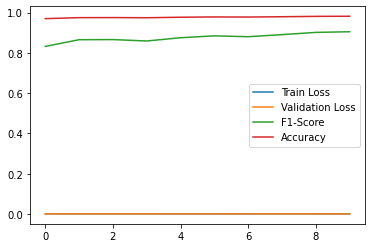

In [15]:
import matplotlib.pyplot as plt 

plt.plot(train_losses)
plt.plot(val_losses)
plt.plot(F1_scores)
plt.plot(accuracies)
plt.legend(["Train Loss", "Validation Loss", "F1-Score", "Accuracy"])
plt.show()

#### Plot some wrong classified samples.


In [ ]:
printloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.Tensor(valid_x), torch.Tensor(valid_y)), batch_size=1)

In [ ]:
# This function was used to find the weaknesses of the network.

def print_false_positive(network, testloader):
    """
    Evaluates the network and prints the false positives samples. 
    
    Parameters:
    
    Returns:
    
    """
    
    counter = 0
    # We do not need any gradiants here, since we do not train the network.
    # We are only interested in the predictions of the network on the testdata. 
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader):
            outputs = network(torch.transpose(inputs[...,None],1,3)).view(-1)
            predicted = (outputs >= threshold) # Predicted is a tensor of booleans 
            predicted = predicted.view(predicted.size(0))
            labels = labels == 1
            if (predicted and not labels):
                title = 'Label: False, Predicted: True'
                fig, ax = plt.subplots()
                plt.imshow(np.array(inputs[0]), cmap='gray')
                ax.set_title(title)
                plt.show()
                counter += 1
                if counter == 20:
                    break
    return counter 
    
print_false_positive(network, printloader)

In [ ]:
def print_false_negative(network, testloader):
    # We do not need any gradiants here, since we do not train the network.
    # We are only interested in the predictions of the network on the testdata. 
    counter = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader):
            outputs = network(torch.transpose(inputs[...,None],1,3)).view(-1)
            predicted = (outputs >= threshold) # Predicted is a tensor of booleans 
            predicted = predicted.view(predicted.size(0))
            labels = labels == 1
            if (not predicted and labels):
                title = 'Label: True, Predicted: False'
                fig, ax = plt.subplots()
                plt.imshow(np.array(inputs[0]), cmap='gray')
                ax.set_title(title)
                plt.show()
                counter += 1
                if counter == 20:
                    break
    return counter
    
print_false_negative(network, printloader)

# Create Heatmaps of Full Size Images

We start with loading some full size images:

In [57]:
def get_samples(dir):
    """returns samples in given directory"""

    # samples will be a list of tuples, each tuple contains a path and a list of coords of a single image
    samples = []
    for root, folders, files in os.walk(dir):
        for folder in folders:
            if folder == 'img':
                for img_root, img_folder, img_files in os.walk(os.path.join(root, folder)):
                    for img_file in img_files:
                        # go find its related annotation file:
                        found_ann = False
                        for ann_root, ann_folder, ann_files in os.walk(os.path.join(root, 'ann')):
                            if found_ann:
                                break
                            for ann_file in ann_files:
                                if img_file in ann_file:
                                    # found a pair!
                                    cur_coords = []
                                    with open(os.path.join(ann_root, ann_file)) as ann_json:
                                        ann_data = json.load(ann_json)
                                    cur_len = len(ann_data['objects'])
                                    if cur_len:
                                        for obj in ann_data['objects']:
                                            cur_coords.append(obj['points']['exterior'][0])
                                        img_path = os.path.join(img_root, img_file)
                                        np_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                                        samples.append((np.array(np_img), cur_coords))
                                    # to prevent unnecessary looping:
                                    found_ann = True
                                    break
    return samples

In [58]:
cur_dir = os.getcwd()
full_size_files = cur_dir + '/Fullsize/'
full_size_images = get_samples(full_size_files)

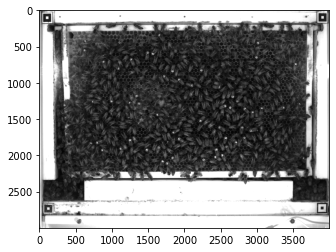

In [62]:
# show one of the full size images:

plt.imshow(full_size_images[0][0], cmap='gray')
plt.show()

### Create Loader with Fullsizeimages

In [65]:
fs_images = []
fs_coords = []

for i in range(len(full_size_images)):
    fs_images.append(full_size_images[i][0])
    fs_coords.append(full_size_images[i][1])

print(len(fs_images))
 t_images = torch.Tensor(fs_images)
# TODO

In [75]:
def heat(network, images):
    """
    Feeds images of any size into the network and returns the belonging heatmaps. 
    
    Parameters:
        network (FCNN): A fully convolutional neural network, that is used to compute a heatmap.
        testloader (torch.utils.data.DataLoader): Dataloader with batch size 1 that contains the
            images you want to compute the heatmaps of
        
    Returns:
        heatmaps ([np.array]): A list which contains a heatmap that is a 2D array for every input image.
    """
    
    heatmaps = []
    print('Creating heatmaps...')
    with torch.no_grad():

        for fs_image, fs_coords in samples:
            t_image = torch.Tensor(fs_image)
#             outputs = network(torch.transpose(inputs[...,None],1,3))
            heatmap = network(torch.transpose(t_image[...,None],1,3)).view(-1)
            heatmaps.append((np.array(torch.transpose(heatmap[0,0,:,:],0,1)),coords))
            
    print('Heatmaps created.')
    return heatmaps

In [76]:
heatmaps = heat(network,full_size_images)

Creating heatmaps...


IndexError: Dimension out of range (expected to be in range of [-3, 2], but got 3)

In [21]:
print(heatmaps[0].shape)

(368, 493)


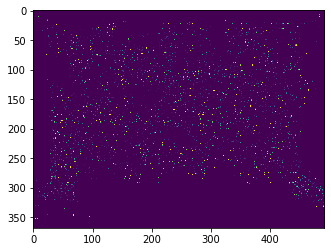

In [22]:
plt.imshow(heatmaps[0], interpolation = 'none')
plt.show()

In [34]:
# Find the local maxima using max pooling:

def non_max_suppression(heatmaps, local_size = 8):
    heatmaps_sup = []
    pooling = nn.MaxPool2d((local_size * 2 - 1), stride = 1, padding = local_size - 1)
    for heatmap in heatmaps:
        max_filter = pooling(torch.tensor(heatmap)[None,...])
        max_filter = np.array(max_filter)
        heatmap = ((heatmap == max_filter) * (heatmap >= 0.8)).astype(int)
        heatmaps_sup.append(heatmap[0,:,:])
        
    return heatmaps_sup
                

In [35]:
local = non_max_suppression([heatmaps[0]],16)

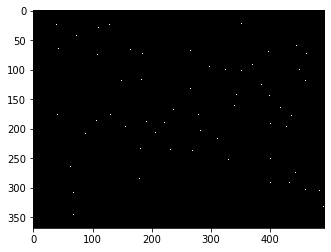

In [36]:
plt.imshow(local[0], interpolation = 'none', cmap = 'gray')
plt.show()

In [55]:
# Get coordinates of local maxima and convert back to full image size coordinates:

def pollen_coordinates(heatmap):
    coordinate_list = []
    h_coordinates = np.argwhere(heatmap == 1)
    for i in range(h_coordinates.shape[0]):
        coordinate_list.append((h_coordinates[i,0] * 2 * 2 * 2 + 28, h_coordinates[i,1] * 2 * 2 * 2 + 28))
    return coordinate_list
    

In [ ]:
image = Image.fromarray(np.uint8(cm.gray(first_heatmap)*255))

In [ ]:
plt.imshow(image, interpolation = 'none')
plt.show()

In [ ]:
image_rescaled = image.resize((4000,3000))

In [ ]:
plt.imshow(image_rescaled, interpolation = 'none')
plt.show()

# Plot Heatmap: Predicted Pollen vs Real Pollen

In [2]:
def guess_plotter(img, network_guess, actual_points):

    np_img = np.array(Image.open(img), dtype=np.uint8)
    main_fig,ax = plt.subplots(1)
    ax.imshow(np_img)

    for coord in actual_points:
        crcl = patches.Circle((coord[0],coord[1]),35,linewidth=4,edgecolor='r',facecolor='none')
        ax.add_patch(crcl)

    for coord in network_guess:
        crcl = patches.Circle((coord[0],coord[1]),20,linewidth=2,edgecolor='b',facecolor='none')
        ax.add_patch(crcl)

    plt.show()

In [ ]:
## We need something like:
# our_images = get_samples('/dir/to/Fullsize/Images')
# for image, coords in our_images:
#     heatimage = heat(network,image_as_loader)
#     local = non_max_suppression([heatimage],16)
#     gussed_coords = pollen_coordinates(local)
#     guess_plotter(image,guessed_coords,coords)